# The Problem:  

    Identifying 100 different objects from Images.
    

# The Value:

    The computer vision can be used in multiple areas, i.e. manufaturing, defense, healthcare and defense.


# The goal:

    Accomplish >65% accuracy, and small false positive. 


# The dataset     

    A dataset of 100 different categories of objects' images, sized 32*32 pixels of color RBG. 
    The URL is https://keras.io/datasets/. Hundreds of thousands of image files are available for 
    both training set and testing set.


# The techniques:       

    The technologies involved will be common python libraries, like numpy, pandas, matplotlib, seaborn. 
    Additional libraries packages, i.e. tensorflow and keras, will be used extensively.
    
    Due to great demand for CPU and memory resources, google colab will be used to run training, testing 
    and  evaluation.

    A special multi-layered deep convolutional neural network will be developed. The deep CNN will be 
    trained to capture different levels of abstraction. Several additional techniques will be applied 
    to increase precision, decrease false positive.
    
    1. Apply data augmentation. 
            
            The image is rotated and left-right flipped to generate 8 orientations. 
            
            
    2. Regularization.
    
            Randomly drop units from neural network to avoid overfitting
    
            kernel regularization as aplying penalties on layer parameters during optimization.

                                               

In [30]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from six.moves import cPickle

import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import img_to_array

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Layer, Input, TimeDistributed
from keras.optimizers import RMSprop
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from keras.datasets import cifar100

In [47]:
# utility functions
def my_confusion_matrix(prediction_classes, label_data):
    """ Purpose: generate n_class by n_class matrix
                 the matrix rows are predicted true indice,
                 the columns are actual true indices
        Input:   predictions_classes being matrix of each event's prediction class, i.e. [34, 45, 23, ...]
                 label_data being matrix of each event's label [[0 0 1 0 ..], [1 0 0 ..], ...]
    
        Output:  confusion_matrix """
    nsize = label_data.shape[1]
    result = np.zeros((nsize,nsize))
    nevents = label_data.shape[0]
    for irow in range(nevents):
        count = 0
        nrow = prediction_classes[irow]
        ncol = label_data[irow].tolist().index(1)
        result[nrow, ncol] += 1
        
    return result

In [48]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
  
#def tf_imgdata_generator(image, label, is_training, batch_size=128):
#    '''Generate digitized (x_train,y_train) dataset'''
    
def mapping_func(image, label):
    '''Preprocess raw image data into trainable input'''
    X = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
    Y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
    return X,Y
  
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )
        Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [32]:
# load dataset
#
batch_size = 64
num_classes = 100
epochs = 100
(x_train,y_train), (x_test, y_test) = cifar100.load_data()

In [33]:
# Here shows the ratio of training vs testing dataset is 5 to 1
#
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)


(50000, 32, 32, 3)
(50000, 1)


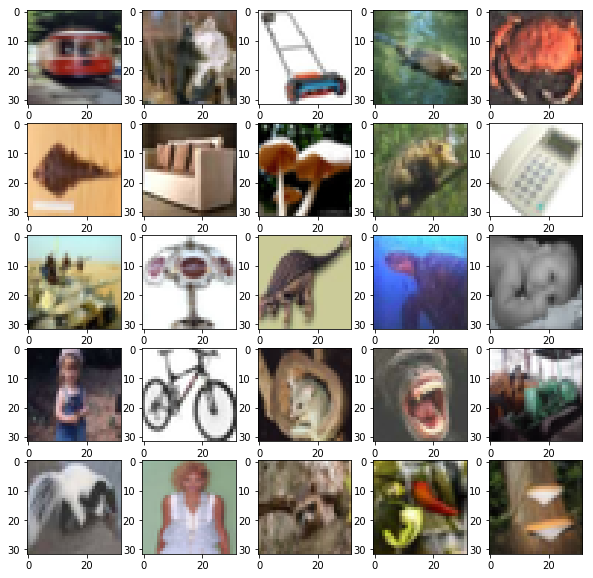

In [7]:
# visualizing data
#
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for j in range(5):
    for i in range(5):
        k = np.random.choice(range(len(x_train)))
        axes[j][i].imshow(x_train[k:k+1][0], interpolation='nearest')

# second CNN model, with varying filters over the layered neural network

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
# normalizing the dataset
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)
 
# creating 8-layered CNN
# weight_delay is learning rate used in CNN
weight_decay = 1e-4
# first convolutional layer 
model = Sequential()
model.add(Conv2D(32, (2,2), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
# second pooling layer
model.add(Conv2D(32, (2,2), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
# third convolutional layer layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
# fourth pooling layer
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
# fifth convolutional layer
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
# sixth pooling layer
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
# seventh convolutional layer
model.add(Conv2D(256, (5,5), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
# eighth pooling layer
model.add(Conv2D(256, (5,5), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
# fit to model
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model02.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model02.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: {} loss: {}'.format(scores[1]*100,scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Epoch 26/125
781/781 [==============================] - 1113s 1s/step - loss: 2.4075 - acc: 0.4971 - val_loss: 2.3449 - val_acc: 0.5164
Epoch 27/125
781/781 [==============================] - 1095s 1s/step - loss: 2.4044 - acc: 0.4982 - val_loss: 2.2887 - val_acc: 0.5310
Epoch 28/125
781/781 [==============================] - 1099s 1s/step - loss: 2.3823 - acc: 0.5059 - val_loss: 2.3150 - val_acc: 0.5236
Epoch 29/125
781/781 [==============================] - 1099s 1s/step - loss: 2.3904 - acc: 0.5027 - val_loss: 2.5450 - val_acc: 0.4860
Epoch 30/125
781/781 [==============================] - 1104s 1s/step - loss: 2.3731 - acc: 0.5091 - val_loss: 2.3017 - val_acc: 0.5327
Epoch 31/125
781/781 [==============================] - 1094s 1s/step - loss: 2.3668 - acc: 0.5124 - val_loss: 2.2877 - val_acc: 0.5461
Epoch 32/125
781/781 [==============================] - 1097s 1s/step - loss: 2.3549 - acc: 0.5181 - val_loss: 2.2522 - val_acc: 0.5465
Epoch 33/125
781/781 [==========================

In [51]:
print('train score = {}'.format(0.6766))
print('test score = {}'.format(0.642))

train score = 0.6766
test score = 0.642


In [23]:
# evaluating the model
from sklearn.metrics import confusion_matrix
#import iterpools

predictions01 = model.predict(x_train, batch_size=10, verbose=0)
predictions_classes01 = model.predict_classes(x_train, batch_size=10, verbose=0)

In [24]:
out_matr = my_confusion_matrix(predictions_classes, y_train)

In [17]:
nsize = 100
colname = np.arange(nsize)
norm = np.zeros((nsize,nsize))
norm_matr = pd.DataFrame(norm, columns=colname)
for icol in range(nsize):
    norm_matr.iloc[:, icol] = out_matr.iloc[:, icol] / np.sum(out_matr.iloc[:, icol])

## confusion matrix's heatmap

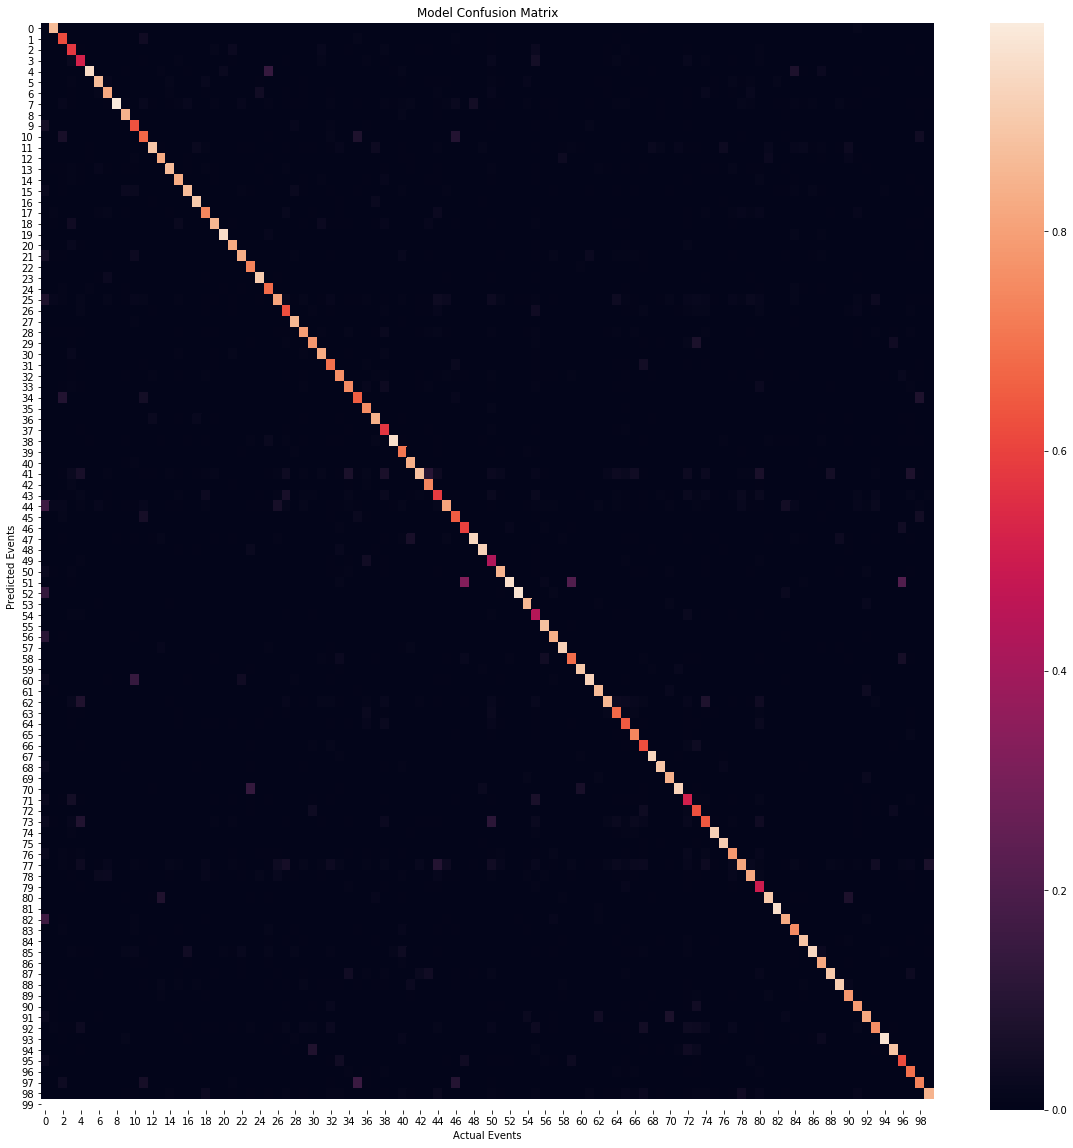

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(norm_matr)
plt.xlabel('Actual Events')
plt.ylabel('Predicted Events')
plt.title('Model Confusion Matrix')
plt.show()

<Figure size 720x2880 with 0 Axes>

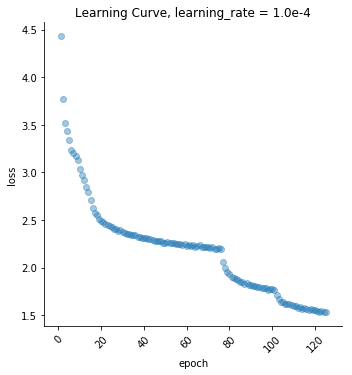

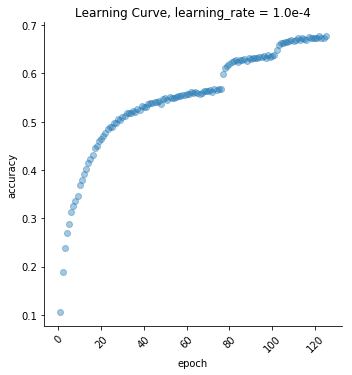

In [21]:
learning_curve = pd.read_csv('curve_loss_accuracy_run2.csv')
fig = plt.figure(figsize=(10,40))
#fig.add_subplot(121)
graph = sns.lmplot(x='epoch', y='loss', data=learning_curve, fit_reg=False, scatter_kws={'alpha':0.4})
plt.xticks(rotation=45)
graph.set_xlabels('epoch')
graph.set_ylabels('loss')
plt.title('Learning Curve, learning_rate = 1.0e-4')

#fig.add_subplot(122)
graph = sns.lmplot(x='epoch', y='accuracy', data=learning_curve, fit_reg=False, scatter_kws={'alpha':0.4})
plt.xticks(rotation=45)
graph.set_xlabels('epoch')
graph.set_ylabels('accuracy')
plt.title('Learning Curve, learning_rate = 1.0e-4')
plt.show()

## more will be found in a separate jupyter notebook